# Determination of a perspective tariff for a telecom company

Customers are offered two tariff plans: "Smart" and "Ultra". 
To adjust the advertising budget the commercial department wants to know which tariff brings more money.

The project conducted a preliminary analysis of tariffs on a small sample of customers. We have the data of 500 Megalyne users at our disposal: 

- who they are?
- where they come from?
- what tariff they use?
- how many calls and messages each sent in 2018?

An analysis of customer behavior will be conducted and a conclusion will be made — which tariff is better.

**Description of tariffs**

**"Smart" tariff:**

1) Monthly fee: 550 rubles

2) Included 500 minutes of conversation, 50 messages and 15 GB of Internet traffic

3) The cost of services in excess of the tariff package:

- a minute of conversation: 3 rubles
- message: 3 rubles
- 1 GB of Internet traffic: 200 rubles 

**"Ultra" tariff**

1) Monthly fee: 1950 rubles

2) 3000 minutes of conversation, 1000 messages and 30 GB of Internet traffic are included

3) The cost of services in excess of the tariff package:

- a minute of conversation: 1 ruble
- message: 1 ruble
- 1 GB of Internet traffic: 150 rubles

**Data description:**

Users table (information about users):

- `user_id` — unique user ID
- `first_name` — user name
- `last_name` — last name of the user
- `age`— user's age (years)
- `reg_date` — tariff activation date (day, month, year)
- `churn_date` — date of termination of use of the tariff (if the value is omitted, the tariff was still valid at the time of data upload)
- `city` — the user's city of residence
- `tariff` — name of the tariff plan

Calls table (information about calls):

- `id` — unique call number
- `call_date` — date of the call
- `duration` — the duration of the call in minutes
- `user_id` — id of the user who made the call

Messages table (information about messages):

- `id` — unique message number
- `message_date` — date of the message
- `user_id` — id of the user who sent the message

Internet table (information about internet sessions):

- `id` — unique session number
- `mb_used` — the amount of Internet traffic spent per session (in megabytes)
- `session_date` — date of the internet session
- `user_id` — user ID

Tariffs table (information about tariffs):

- `tariff_name` — name of the tariff
- `rub_monthly_fee` — monthly subscription fee in rubles
- `minutes_included` — the number of minutes of conversation per month included in the subscription fee
- `messages_included` — the number of messages per month included in the subscription fee
- `mb_per_month_included` — the amount of Internet traffic included in the subscription fee (in megabytes)
- `rub_per_minute` — the cost of a minute of conversation over the tariff package (for example, if the tariff has 100 minutes of conversation per month, then a fee will be charged from 101 minutes)
- `rub_per_message` — the cost of sending a message over the tariff package
- `rub_per_gb` — the cost of an additional gigabyte of Internet traffic over the tariff package (1 gigabyte = 1024 megabytes)

# Step 1. Open the data files and study the general information

In [1]:
import pandas as pd
import math as mt
import numpy as np
import datetime as dt
from functools import reduce
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
data_calls = pd.read_csv('calls.csv')
data_inet = pd.read_csv('internet.csv')
data_mes = pd.read_csv('messages.csv')
data_trf = pd.read_csv('tariffs.csv')
data_user = pd.read_csv('users.csv')

In [3]:
# display(data_calls)
# display(data_inet)
# display(data_mes)
# display(data_trf)
# display(data_user)

# Шаг 2. Подготовьте данные

##  "data_calls" preprocessing

In [4]:
display(data_calls)
data_calls.info()
# DROP DUPLICATES
data_calls = data_calls.drop_duplicates()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
# round the time up according to the tariff condition and convert them to integer to save RAM
data_calls['duration'] = np.ceil(data_calls['duration']).astype(int)

# Change data type to datetime
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y.%m.%d')

# add a column with month
data_calls['month'] = data_calls['call_date'].dt.month

# the number of calls made for each user and spent minutes of conversation by month
calls_by_month = data_calls.pivot_table(index=['user_id','month'], values='duration', aggfunc=['count','sum']) 
calls_by_month.columns = ['calls_count','sum_duration']
print(calls_by_month)

               calls_count  sum_duration
user_id month                           
1000    5               22           159
        6               43           172
        7               47           340
        8               52           408
        9               58           466
...                    ...           ...
1498    10              41           247
1499    9                9            70
        10              68           449
        11              74           612
        12              69           492

[3174 rows x 2 columns]


In [6]:
data_calls.info()
display(data_calls)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int32         
 3   user_id    202607 non-null  int64         
 4   month      202607 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(2), object(1)
memory usage: 8.5+ MB


,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-26,1,1499,12
202603,1499_216,2018-10-18,19,1499,10
202604,1499_217,2018-11-10,11,1499,11
202605,1499_218,2018-10-06,5,1499,10


##  "data_inet" preprocessing

In [7]:
display(data_inet)
data_inet.info()

# DROP DUPLICATES 
data_inet = data_inet.drop_duplicates()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [8]:
# Change data type to datetime
data_inet['session_date'] = pd.to_datetime(data_inet['session_date'], format='%Y.%m.%d')

# create column with months 
data_inet['month'] = data_inet['session_date'].dt.month

# the amount of Internet traffic used by months [GB]
spent_inet_mb = data_inet.pivot_table(index=['user_id','month'], values=['mb_used'],aggfunc='sum')
#print(spent_inet_mb.head(10))

# remove the column "Unnamed: 0" which repeats the indexes of "data_inet"
data_inet.pop('Unnamed: 0')

0              0
1              1
2              2
3              3
4              4
           ...  
149391    149391
149392    149392
149393    149393
149394    149394
149395    149395
Name: Unnamed: 0, Length: 149396, dtype: int64

In [9]:
display(data_inet.head(10))
data_inet.info()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9
5,1000_5,399.97,2018-10-02,1000,10
6,1000_6,540.08,2018-09-07,1000,9
7,1000_7,415.70,2018-07-11,1000,7
8,1000_8,505.40,2018-10-08,1000,10
9,1000_9,345.54,2018-09-03,1000,9


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
 4   month         149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 6.8+ MB


## "data_mes" preprocessing

In [10]:
display(data_mes)
data_mes.info()
data_mes = data_mes.drop_duplicates()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [11]:
# Change data type to datetime
data_mes['message_date'] = pd.to_datetime(data_mes['message_date'], format='%Y.%m.%d')

# DROP DUPLICATES
data_mes = data_mes.drop_duplicates()

# create months column
data_mes['month'] = data_mes['message_date'].dt.month

# number of sent messages per month
send_mess_by_month = data_mes.pivot_table(index=['user_id','month'],\
                                          values='message_date',aggfunc='count')
display(send_mess_by_month)

message_date
user_id month              
1000    5                22
        6                60
        7                75
        8                81
        9                57
...                     ...
1498    10               42
1499    9                11
        10               48
        11               59
        12               66

[2717 rows x 1 columns]

In [12]:
display(data_mes)
data_mes.info()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
...,...,...,...,...
123031,1499_179,2018-12-12,1499,12
123032,1499_180,2018-09-28,1499,9
123033,1499_181,2018-09-27,1499,9
123034,1499_182,2018-11-15,1499,11


<class 'pandas.core.frame.DataFrame'>
Int64Index: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
 3   month         123036 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.7+ MB


## "data_trf" preprocessing

In [13]:
display(data_trf)
data_trf.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


## "data_user" preprocessing

In [14]:
# Change data type to datetime
data_user['reg_date'] = pd.to_datetime(data_user['reg_date'], format='%Y.%m.%d')
data_user['churn_date'] = pd.to_datetime(data_user['churn_date'], format='%Y.%m.%d')

# DROP DUPLICATES
data_user = data_user.drop_duplicates()

In [15]:
display(data_user)
data_user.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 35.2+ KB


### Merging pivot tables into one

In [16]:
df = [calls_by_month, spent_inet_mb, send_mess_by_month]
grouped_data = reduce(lambda x, y: pd.merge(x, y, on=['user_id', 'month'], how ='outer'), df)
#grouped_data = grouped_data.reset_index() 



In [17]:
# missing values are replaced by zeros
grouped_data = grouped_data.fillna(0)

In [18]:
grouped_data.head(10)

calls_count  sum_duration   mb_used  message_date
user_id month                                                   
1000    5             22.0         159.0   2253.49          22.0
        6             43.0         172.0  23233.77          60.0
        7             47.0         340.0  14003.64          75.0
        8             52.0         408.0  14055.93          81.0
        9             58.0         466.0  14568.91          57.0
        10            57.0         350.0  14702.49          73.0
        11            43.0         338.0  14756.47          58.0
        12            46.0         333.0   9817.61          70.0
1001    11            59.0         430.0  18429.34           0.0
        12            63.0         414.0  14036.66           0.0

## Revenue from each user

**Calculate monthly revenue per user:**

- subtract the free limit from the total number of calls, messages and internet traffic;
- multiply the remainder by the value from the tariff plan;
- add the subscription fee corresponding to the tariff plan.

In [19]:
# add the name of the tariff used for each user

for user in grouped_data.index:
    grouped_data.loc[user, 'tariff'] = data_user.loc[user[0] - 1000, 'tariff']

In [20]:
grouped_data

calls_count  sum_duration   mb_used  message_date tariff
user_id month                                                          
1000    5             22.0         159.0   2253.49          22.0  ultra
        6             43.0         172.0  23233.77          60.0  ultra
        7             47.0         340.0  14003.64          75.0  ultra
        8             52.0         408.0  14055.93          81.0  ultra
        9             58.0         466.0  14568.91          57.0  ultra
...                    ...           ...       ...           ...    ...
1489    8              0.0           0.0  11050.56          17.0  smart
        9              0.0           0.0  17206.30          32.0  smart
        10             0.0           0.0  19559.44          21.0  smart
        11             0.0           0.0  17491.56          20.0  smart
        12             0.0           0.0  17322.51          35.0  smart

[3214 rows x 5 columns]

In [21]:
def get_revenue (row):
    messeges = row['message_date']
    calls_duration = row['sum_duration']
    mb_used = row['mb_used']
    tariff = row['tariff']
        
    if tariff == 'smart':
        extra_duration = calls_duration - data_trf.loc[0,'minutes_included']
        extra_mb_used = mb_used  - (data_trf.loc[0,'mb_per_month_included'])
        extra_messeges = messeges - data_trf.loc[0,'messages_included']

        if extra_duration < 0:
            extra_duration = 0
        if extra_mb_used < 0:
            extra_mb_used = 0
        if extra_messeges < 0:
            extra_messeges = 0

        return (extra_duration * data_trf.loc[0,'rub_per_minute'] + 
               extra_mb_used * (data_trf.loc[0,'rub_per_gb'] / 1024) + 
               extra_messeges * data_trf.loc[0,'rub_per_message'] + 
               data_trf.loc[0,'rub_monthly_fee'])
    else:
        extra_duration = calls_duration - data_trf.loc[1,'minutes_included']
        extra_mb_used = mb_used - (data_trf.loc[1,'mb_per_month_included'])
        extra_messeges = messeges - data_trf.loc[1,'messages_included']

        if extra_duration < 0:
            extra_duration = 0
        if extra_mb_used < 0:
            extra_mb_used = 0
        if extra_messeges < 0:
            extra_messeges = 0

        return (extra_duration * data_trf.loc[1,'rub_per_minute'] + 
               extra_mb_used * data_trf.loc[1,'rub_per_gb'] / 1024 + 
               extra_messeges * data_trf.loc[1,'rub_per_message'] + 
               data_trf.loc[1,'rub_monthly_fee'])    

In [22]:
grouped_data['revenue'] = grouped_data.apply(get_revenue,axis=1)

In [23]:
display(grouped_data.head(10))

calls_count  sum_duration   mb_used  message_date tariff  \
user_id month                                                             
1000    5             22.0         159.0   2253.49          22.0  ultra   
        6             43.0         172.0  23233.77          60.0  ultra   
        7             47.0         340.0  14003.64          75.0  ultra   
        8             52.0         408.0  14055.93          81.0  ultra   
        9             58.0         466.0  14568.91          57.0  ultra   
        10            57.0         350.0  14702.49          73.0  ultra   
        11            43.0         338.0  14756.47          58.0  ultra   
        12            46.0         333.0   9817.61          70.0  ultra   
1001    11            59.0         430.0  18429.34           0.0  smart   
        12            63.0         414.0  14036.66           0.0  smart   

                   revenue  
user_id month               
1000    5      1950.000000  
        6      1950.000000  
        7      1950.000000  
        8      1950.000000  
        9      1950.000000  
        10     1950.000000  
        11     1950.000000  
        12     1950.000000  
1001    11     1149.480469  
        12      550.000000

# Step 3: Analyze the data

Describe the behavior of the operator's customers based on the sample.
- How many minutes of conversation?
- how many messages?
- how much Internet traffic is required by users of each tariff per month?

In [24]:
# how many minutes, messages, and megabytes for each user per month (MEDIAN)
median_data = grouped_data.pivot_table(index='user_id',values=['sum_duration','message_date','revenue','mb_used'], aggfunc="median")

for i in data_user['user_id']:
    median_data.loc[i, 'tariff'] = data_user.loc[i-1000,'tariff']
median_data = median_data.dropna()
display(median_data.head())


# how many minutes, messages, and megabytes for each user per month (AVERAGE)
mean_data = grouped_data.pivot_table(index='user_id',values=['sum_duration','message_date','mb_used','revenue'], aggfunc='mean')

for i in data_user['user_id']:
    mean_data.loc[i, 'tariff'] = data_user.loc[i-1000,'tariff']
mean_data = mean_data.dropna()
display(mean_data.head())

,mb_used,message_date,revenue,sum_duration,tariff
user_id,,,,,
1000,14312.42,65.0,1950.000000,339.0,ultra
1001,16233.00,0.0,849.740234,422.0,smart
1002,17580.10,11.0,983.613281,214.0,smart
1003,11356.89,83.0,1950.000000,824.0,ultra
1004,17810.53,154.5,1950.000000,132.5,ultra


,mb_used,message_date,revenue,sum_duration,tariff
user_id,,,,,
1000,13424.038750,62.0,1950.000000,320.750000,ultra
1001,16233.000000,0.0,849.740234,422.000000,smart
1002,16576.645714,10.0,954.337333,216.714286,smart
1003,11456.128000,76.0,1950.000000,764.400000,ultra
1004,18629.935000,149.0,1950.000000,123.375000,ultra


**mean, variance and standard deviation**

In [25]:
statistics_data = grouped_data.pivot_table(index=['tariff'],\
                                           values=['sum_duration','message_date','mb_used'],\
                                           aggfunc={'sum_duration':['median',np.var, np.std],\
                                                    'message_date':['median',np.var, np.std],\
                                                    'mb_used':['median',np.var, np.std]})

display(statistics_data)

mb_used                             message_date             \
          median           std           var       median        std   
tariff                                                                 
smart   16506.84   5870.476681  3.446250e+07         28.0  28.227876   
ultra   19308.01  10087.170752  1.017510e+08         38.0  47.804457   

                    sum_duration                             
                var       median         std            var  
tariff                                                       
smart    796.812958        422.0  190.313730   36219.315784  
ultra   2285.266143        518.0  317.606098  100873.633397

- Plot histograms;
- Describe distributed.

The minutes of conversation, the number of messages and the amount of Internet traffic spent on the `'Ultra tariff'` have a greater dispersion compared to the `'Smart tariff'`. The medians for the above characteristics are also shifted upwards. In addition anomalous values under the cheaper tariff are significantly higher.

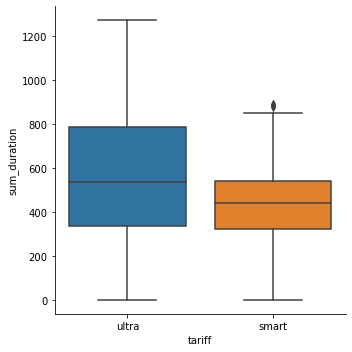

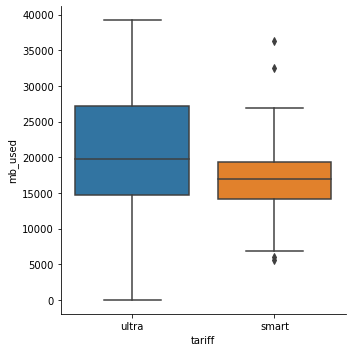

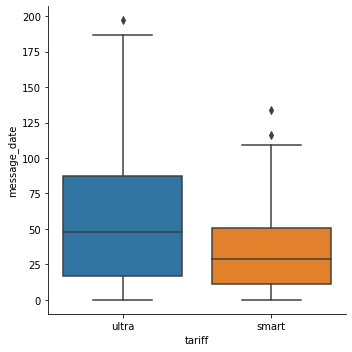

In [26]:
for i in ['sum_duration', 'mb_used', 'message_date']:    
    sb.catplot(x="tariff", y=i, kind="box", data=median_data, orient='v')

In [27]:
def det_whiskers(column):
    descr = grouped_data[column].describe()
    
    iqr = descr[6] - descr[4] 
    
    left_whisker = round(descr[4] - 1.5 * iqr, 2)
    right_whisker = round(descr[6] + 1.5 * iqr, 2)
    
    if left_whisker < descr[3]: left_whisker = descr[3] 
        
    if right_whisker > descr[7]: right_whisker = descr[7]
        
    #return (f'{column}, Левый ус: {left_whisker}, Правый ус: {right_whisker}')
    return [left_whisker,right_whisker]

- According to the histograms it is clearly seen that the dispersion for the `"Smart tariff"` is less than for users with the `"Ultra tariff"` in all indicators: by the duration of the call, the number of messages and the used Internet traffic.

- In other words, the behavior of users of the `"Ultra tariff"` is more diverse in terms of the consumption of telecommunications services.

- Users of an expensive tariff are more free to choose how to use the volumes of the tariff package: perhaps, using an expensive tariff helps them not to think that at some point their Internet will turn off or the package will end by minutes of conversation.

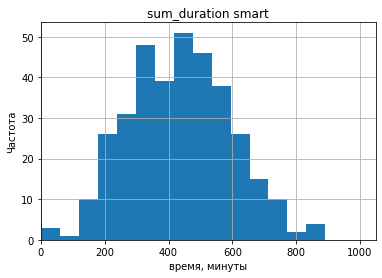

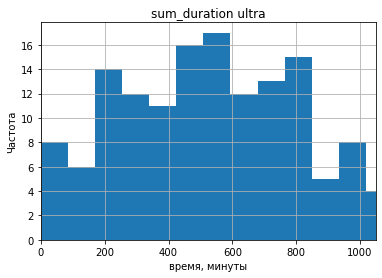

In [28]:
# plot a histogram with a column median_data['sum_duration']
for i in ['smart', 'ultra']:
    median_data.loc[median_data['tariff'] == i].hist('sum_duration',bins=15)
    plt.xlim(det_whiskers('sum_duration')[0], det_whiskers('sum_duration')[1])
    plt.title('sum_duration '+ i +'')
    plt.xlabel('время, минуты')
    plt.ylabel('Частота')

<AxesSubplot:xlabel='month', ylabel='sum_duration'>

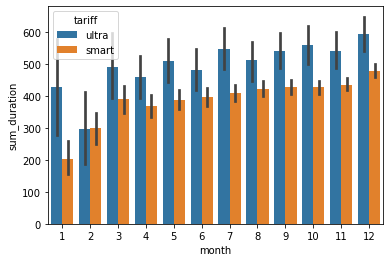

In [29]:
sb.barplot(x="month", y="sum_duration", data=grouped_data.reset_index(), hue = 'tariff')

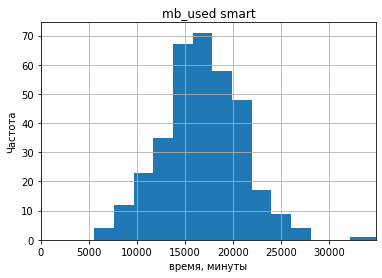

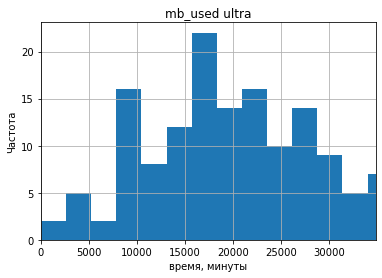

In [30]:
# plot a histogram with a column median_data['sum_duration']
for i in ['smart', 'ultra']:
    median_data.loc[median_data['tariff'] == i].hist('mb_used',bins=15)
    plt.xlim(det_whiskers('mb_used')[0], det_whiskers('mb_used')[1])
    plt.title('mb_used '+ i +'')
    plt.xlabel('время, минуты')
    plt.ylabel('Частота')

<AxesSubplot:xlabel='month', ylabel='mb_used'>

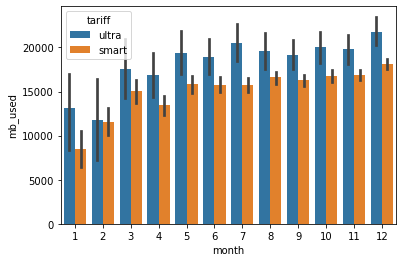

In [31]:
sb.barplot(x="month", y="mb_used", data=grouped_data.reset_index(), hue = 'tariff')

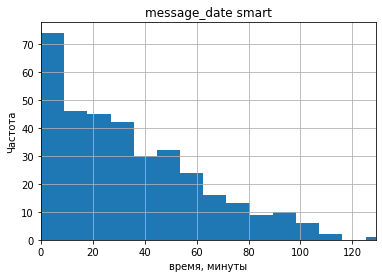

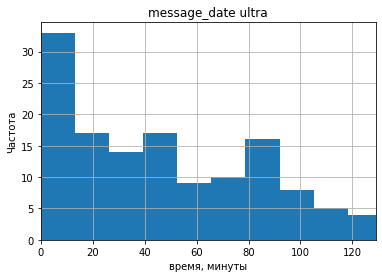

In [32]:
# plot a histogram with a column median_data['message_date']
for i in ['smart', 'ultra']:
    median_data.loc[median_data['tariff'] == i].hist('message_date',bins=15)
    plt.xlim(det_whiskers('message_date')[0], det_whiskers('message_date')[1])
    plt.title('message_date '+ i +'')
    plt.xlabel('время, минуты')
    plt.ylabel('Частота')

<AxesSubplot:xlabel='month', ylabel='message_date'>

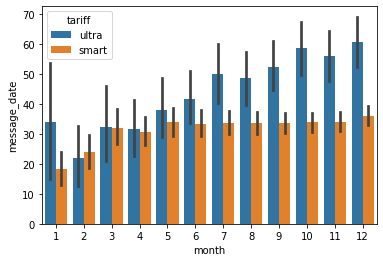

In [33]:
sb.barplot(x="month", y="message_date", data=grouped_data.reset_index(), hue = 'tariff')

<AxesSubplot:xlabel='revenue', ylabel='Count'>

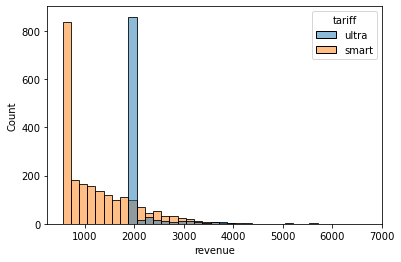

In [34]:
sb.histplot(data = grouped_data.reset_index(),  x = "revenue", hue = "tariff")

<AxesSubplot:xlabel='month', ylabel='revenue'>

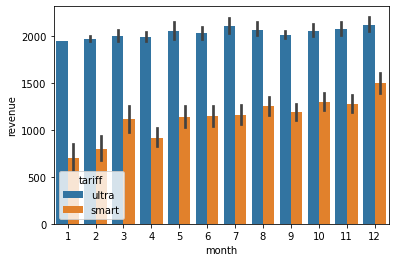

In [35]:
sb.barplot(x="month", y="revenue", data=grouped_data.reset_index(), hue = 'tariff')

# Step 4. Hypothesis testing

`H0` — the average revenue of `"Ultra tariff"` users is equal to the average revenue of `"Smart tariff"` users.

`H1` - the average revenue of users of the `"Ultra tariff"` and `"Smart tariffs` are different.

The average values of revenue by tariffs differ by almost 2 times. If a user has a `"Smart tariff"` with a subscription fee of 550 rubles then he will most likely pay much more by the end of the month due to a lack of services within the tariff package.

In conclusion, it can be confirmed with 99% certainty that Megaline's revenues per user under the `"Ultra tariff"` are really different compared to the revenues from the `"Smart tariff"`.

In [36]:
# Testing the hypothesis about the equality of the mean of two general 
# populations based on samples taken from them
ultra = grouped_data.query('tariff == "ultra"')['revenue']
smart = grouped_data.query('tariff == "smart"')['revenue']

a = 0.05
# equal_var - whether to consider equal to the sample variances the default value is True
results = st.ttest_ind(ultra, smart, equal_var=False)

print('p_value:', results.pvalue)

if (results.pvalue < a):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p_value: 1.6264184497192716e-298
Отвергаем нулевую гипотезу


In [37]:
grouped_data.pivot_table(index='tariff', values='revenue', aggfunc='median')

,revenue
tariff,
smart,957.978516
ultra,1950.000000



`H0` — the average revenue of users from Moscow is equal to the average revenue of users from other regions.

`H1` — the average revenue of users from Moscow differs from the average revenue of users from other regions.

α=5%

This statistical test did not give an opportunity to disprove the initial hypothesis that the income from users from Moscow and from other regions is almost equal.

If we rejected the null hypothesis and stated that Megaline's income from each user in Moscow differs from income in other regions we would be wrong with a probability of 50.3%.

In [38]:
# add the name of the settlement for each user
for user in grouped_data.index:
    grouped_data.loc[user, 'city'] = data_user.loc[user[0]-1000, 'city']

moscow = grouped_data.query('city == "Москва"')['revenue']
regions = grouped_data.query('city != "Москва"')['revenue']

a = 0.05

results = st.ttest_ind(moscow, regions, equal_var=False)

print('p-p_value:', results.pvalue)

if (results.pvalue < a):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-p_value: 0.45036189303337393
Не получилось отвергнуть нулевую гипотезу


In [39]:
display(moscow)

user_id  month
1001     11       1149.480469
         12        550.000000
1003     8        1950.000000
         9        1950.000000
         10       1950.000000
                     ...     
1490     9         550.000000
         10       1586.126953
         11       1204.816406
         12        633.152344
1476     4        1950.000000
Name: revenue, Length: 611, dtype: float64

In [40]:
display(grouped_data)

calls_count  sum_duration   mb_used  message_date tariff  \
user_id month                                                             
1000    5             22.0         159.0   2253.49          22.0  ultra   
        6             43.0         172.0  23233.77          60.0  ultra   
        7             47.0         340.0  14003.64          75.0  ultra   
        8             52.0         408.0  14055.93          81.0  ultra   
        9             58.0         466.0  14568.91          57.0  ultra   
...                    ...           ...       ...           ...    ...   
1489    8              0.0           0.0  11050.56          17.0  smart   
        9              0.0           0.0  17206.30          32.0  smart   
        10             0.0           0.0  19559.44          21.0  smart   
        11             0.0           0.0  17491.56          20.0  smart   
        12             0.0           0.0  17322.51          35.0  smart   

                   revenue             city  
user_id month                                
1000    5      1950.000000        Краснодар  
        6      1950.000000        Краснодар  
        7      1950.000000        Краснодар  
        8      1950.000000        Краснодар  
        9      1950.000000        Краснодар  
...                    ...              ...  
1489    8       550.000000  Санкт-Петербург  
        9       910.605469  Санкт-Петербург  
        10     1370.203125  Санкт-Петербург  
        11      966.320313  Санкт-Петербург  
        12      933.302734  Санкт-Петербург  

[3214 rows x 7 columns]

In [41]:
def get_region(city):
    if city == 'Москва': 
        return 'Москва'
    else: 
        return 'Другой регион'
    
grouped_data['region'] = grouped_data['city'].apply(get_region)
grouped_data.pivot_table(index='region', values='revenue', aggfunc='median')

,revenue
region,
Другой регион,1513.873047
Москва,1699.357422


#  General conclusion

According to the results of statistical analysis the income from the `"Ultra tariff"` is greater than from the `"Smart tariff"`: on average, Megaline receives 1950 rubles and 988 rubles from one user per month.

Features of the use of tariffs are as follows:

`"Smart tariff"` users do not have enough services within the tariff package: in addition to the subscription fee users on average pay more than 400 rubles monthly (~ 75%).
Users of the `"Ultra tariff"`, on the contrary, do not use the tariff package in full.
Average revenues from users in Moscow do not differ from those in other localities: the difference is not statistically significant (p-value: 0.503) and amounts to 186 rubles: 1699 rubles. in Moscow against 1513 rubles in other settlements.